# Examples of RNN with Keras

In [167]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
%matplotlib inline

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Activation

## Example from [net](https://gist.github.com/hnykda/c362f0ad488e3b289394)

In [212]:
import pandas as pd

flow = (list(range(1,10,1)) + list(range(10,1,-1)))*100
pdata = pd.DataFrame({"a":flow, "b":flow})
pdata.b = pdata.b.shift(9)
data = pdata.iloc[10:]
data += 0.5 * np.random.randn(*data.shape)

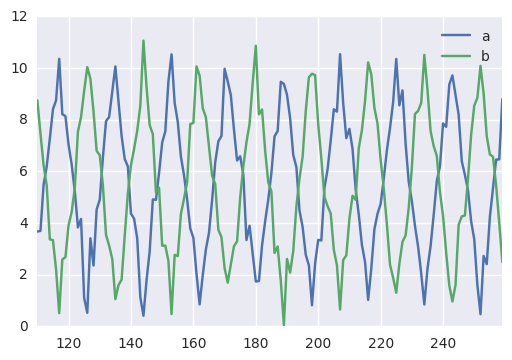

In [236]:
lstart = 100
lend = 250
pd.DataFrame(data[lstart:lend]).plot()  

In [184]:
def _load_data(data, n_prev = 100):
    """
    data should be pd.DataFrame()
    """

    docX, docY = [], []
    for i in range(len(data)-n_prev):
        docX.append(data.iloc[i:i+n_prev].as_matrix())
        docY.append(data.iloc[i+n_prev].as_matrix())
    alsX = np.array(docX)
    alsY = np.array(docY)

    return alsX, alsY

def train_test_split(df, test_size=0.1):
    """
    This just splits data to training and testing parts
    """
    ntrn = int(round(len(df) * (1 - test_size)))

    X_train, y_train = _load_data(df.iloc[0:ntrn])
    X_test, y_test = _load_data(df.iloc[ntrn:])

    return (X_train, y_train), (X_test, y_test)

In [247]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM

in_out_neurons = 2
hidden_neurons = 50

model = Sequential()

# n_prev = 100, 2 values per x axis
model.add(LSTM(hidden_neurons, input_shape=(100, 2)))
model.add(Dense(in_out_neurons))
model.add(Activation("linear"))

model.compile(loss="mean_squared_error",
    optimizer="rmsprop",
    metrics=['accuracy'])

Separate data to train/test sets:

Idea : 

Let we have `{t_i, v_i}` with `i` between 0 and N from input data. E.g. : 

```
t: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
v: a b c d e f g h i j k  l  m  n  o  p  
```
Let us take 5 as test size and 2 as sliding window size

```
Train                     | Test
t: 0 1 2 3 4 5 6 7 8 9 10 | 11 12 13 14 15
v: a b c d e f g h i j k  | l  m  n  o  p  
```

Thus, train dataset : 

```
X_train : [ (a,b), (b,c), (c,d), (d,e), (e,f), (f,g), (g,h), (h,i), (i,j) ]
Y_train : [   c,     d,     e,     f,     g,     h,     i,     j,     k   ] 
```
and test dataset : 

```
X_test : [ (l,m), (m, n), (n, o) ]
Y_test : [   n,     o,      p    ]
```


In [248]:
(X_train, y_train), (X_test, y_test) = train_test_split(data)

In [249]:
model.fit(X_train, y_train, batch_size=700, nb_epoch=75, validation_data=(X_test, y_test), verbose=1)
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

predicted = model.predict(X_test, batch_size=700)

Train on 1511 samples, validate on 79 samples
Epoch 1/75
1511/1511 [==============================] - 1s - loss: 39.0584 - acc: 0.4997 - val_loss: 34.7594 - val_acc: 0.5063
Epoch 2/75
1511/1511 [==============================] - 1s - loss: 34.5133 - acc: 0.4997 - val_loss: 31.4162 - val_acc: 0.5063
Epoch 3/75
1511/1511 [==============================] - 1s - loss: 31.2333 - acc: 0.4997 - val_loss: 28.4378 - val_acc: 0.5063
Epoch 4/75
1511/1511 [==============================] - 1s - loss: 28.2810 - acc: 0.4997 - val_loss: 25.6782 - val_acc: 0.5063
Epoch 5/75
1511/1511 [==============================] - 1s - loss: 25.5776 - acc: 0.4997 - val_loss: 23.2512 - val_acc: 0.5063
Epoch 6/75
1511/1511 [==============================] - 1s - loss: 23.2055 - acc: 0.4997 - val_loss: 21.0349 - val_acc: 0.5063
Epoch 7/75
1511/1511 [==============================] - 1s - loss: 21.0056 - acc: 0.4997 - val_loss: 18.9060 - val_acc: 0.6835
Epoch 8/75
1511/1511 [==============================] - 1s - loss

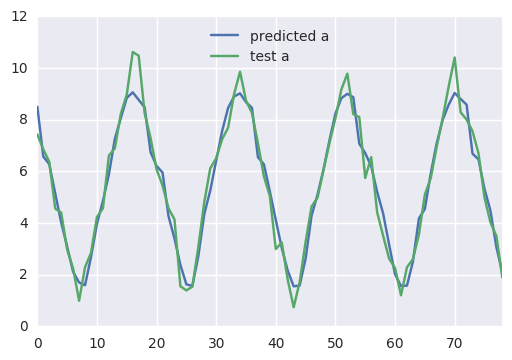

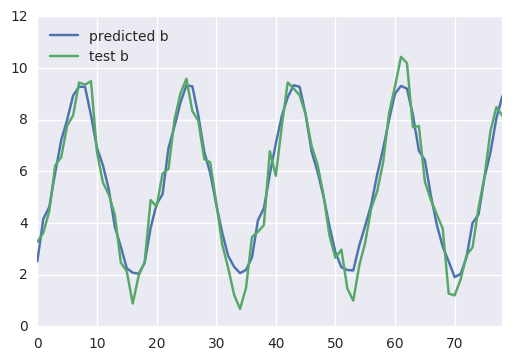

In [250]:
indices = data.index.values[lstart:lend]
pd.DataFrame({'test a': y_test[...,0], 'predicted a': predicted[...,0]}).plot()
pd.DataFrame({'test b': y_test[...,1], 'predicted b': predicted[...,1]}).plot()

## Example from Keras site [stateful_lstm.py](https://github.com/fchollet/keras/blob/master/examples/stateful_lstm.py)

Example script showing how to use stateful RNNs
to model long sequences efficiently.

In [264]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [265]:
# since we are using stateful rnn tsteps can be set to 1
tsteps = 1
batch_size = 25
epochs = 25
# number of elements ahead that are used to make the prediction
lahead = 1

In [266]:
def gen_cosine_amp(amp=100, period=1000, x0=0, xn=50000, step=1, k=0.0001):
    """Generates an absolute cosine time series with the amplitude
    exponentially decreasing
    Arguments:
        amp: amplitude of the cosine function
        period: period of the cosine function
        x0: initial x of the time series
        xn: final x of the time series
        step: step of the time series discretization
        k: exponential rate
    """
    cos = np.zeros(((xn - x0) * step, 1, 1))
    for i in range(len(cos)):
        idx = x0 + i * step
        cos[i, 0, 0] = amp * np.cos(2 * np.pi * idx / period)
        cos[i, 0, 0] = cos[i, 0, 0] * np.exp(-k * idx)
    return cos

In [274]:
print('Generating Data')
cos = gen_cosine_amp()
print('Input shape:', cos.shape)

expected_output = np.zeros((len(cos), 1))
for i in range(len(cos) - lahead):
    expected_output[i, 0] = np.mean(cos[i + 1:i + lahead + 1])
       
print('Output shape')
print(expected_output.shape)

Generating Data
Input shape: (50000, 1, 1)
Output shape
(50000, 1)


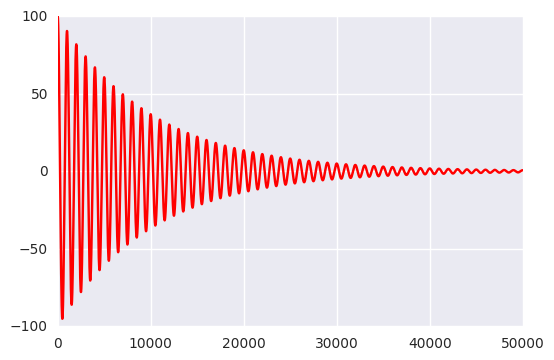

In [282]:
xaxis = np.arange(0, 50000, 1)
plt.plot(xaxis, cos[:,0,0], 'r-')

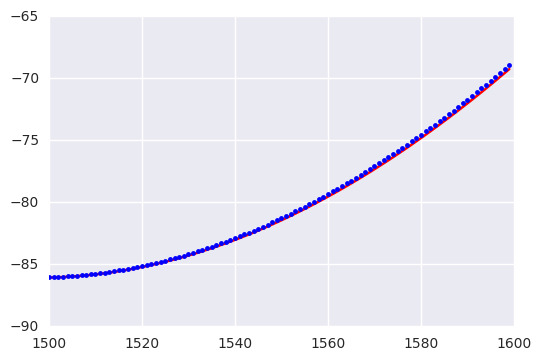

In [284]:
lstart=1500
lend=1600
plt.plot(xaxis[lstart:lend], cos[lstart:lend,0,0], 'r-')
plt.plot(xaxis[lstart:lend], expected_output[lstart:lend,0], 'b.')

In [285]:
print('Creating Model')
model = Sequential()
model.add(LSTM(50,
               batch_input_shape=(batch_size, tsteps, 1),
               return_sequences=True,
               stateful=True))
model.add(LSTM(50,
               return_sequences=False,
               stateful=True))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop')

Creating Model


In [286]:
print('Training')
for i in range(epochs):
    print('Epoch', i, '/', epochs)
    model.fit(cos,
              expected_output,
              batch_size=batch_size,
              verbose=1,
              nb_epoch=1,
              shuffle=False)
    model.reset_states()

Training
Epoch 0 / 25
Epoch 1/1
50000/50000 [==============================] - 14s - loss: 341.2799    
Epoch 1 / 25
Epoch 1/1
50000/50000 [==============================] - 13s - loss: 162.2280    
Epoch 2 / 25
Epoch 1/1
50000/50000 [==============================] - 13s - loss: 86.8497    
Epoch 3 / 25
Epoch 1/1
50000/50000 [==============================] - 13s - loss: 51.3836    
Epoch 4 / 25
Epoch 1/1
50000/50000 [==============================] - 13s - loss: 33.1931    
Epoch 5 / 25
Epoch 1/1
50000/50000 [==============================] - 13s - loss: 23.4784    
Epoch 6 / 25
Epoch 1/1
50000/50000 [==============================] - 13s - loss: 17.7442    
Epoch 7 / 25
Epoch 1/1
50000/50000 [==============================] - 13s - loss: 13.6544    
Epoch 8 / 25
Epoch 1/1
50000/50000 [==============================] - 13s - loss: 10.8811    
Epoch 9 / 25
Epoch 1/1
50000/50000 [==============================] - 13s - loss: 9.0613    
Epoch 10 / 25
Epoch 1/1
50000/50000 [=============

KeyboardInterrupt: 

In [287]:
print('Predicting')
predicted_output = model.predict(cos, batch_size=batch_size)

Predicting


Plotting Results


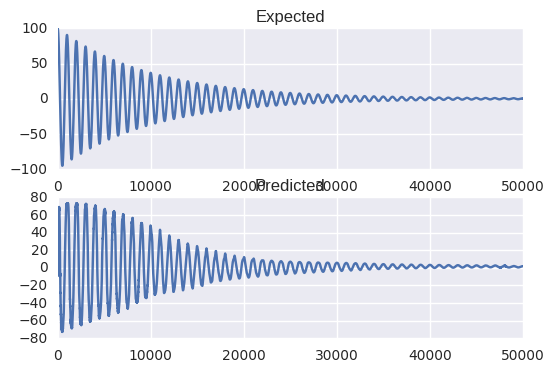

In [288]:
print('Plotting Results')
plt.subplot(2, 1, 1)
plt.plot(expected_output)
plt.title('Expected')
plt.subplot(2, 1, 2)
plt.plot(predicted_output)
plt.title('Predicted')
plt.show()